In [1]:
import urllib
import re
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf

def lin_func(x,m,c):
    y = m*x + c
    return y

def read_data(targ):
    ins = "wfc3-uvis-acs-wfc"
    filt = "multi"
    exteng = "1"

    url = "https://archive.stsci.edu/hlsps/hugs/ngc"+targ+"/hlsp_hugs_hst_"+ins+"_ngc"+targ+"_"+filt+"_v1_catalog-meth"+exteng+".txt"
    file = urllib.request.urlopen(url)   

    ptr = 1
    hd = []

    hd.append("Nan") 
    hd.append("X")  
    hd.append("Y")

    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt", 'w') as f1, open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'w') as f2:
        for line in file:
            line = line.decode("utf-8")
            f2.write(line)
            if ptr > 54:    
                f1.write(re.sub('[\t ]+',' ', line))
            ptr += 1        

    with open(r"D:\IIT material\Krittika python project\NGC"+targ+" header.txt", 'r') as fr:
        lines = fr.readlines()

        for i in range(14, 50):
            hd.append(lines[i])


    file_path = r"D:\IIT material\Krittika python project\NGC"+targ+" data.txt"

    df = pd.read_csv(file_path, sep = ' ')

    df.columns = hd

    df.drop(['Nan'], inplace=True, axis=1)

    df.drop(df[df['# Col. 33: Membership Probability [-1.0: not available]\n'] < 90].index, inplace = True)
    df.drop(df[df['# Col.  3: F275W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col.  9: F336W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 15: F438W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 27: F814W calibrated magnitude\n'] < 0].index, inplace = True)
    df.drop(df[df['# Col. 21: F606W calibrated magnitude\n'] < 0].index, inplace = True)
    df['Color index'] = df['# Col.  9: F336W calibrated magnitude\n'] - df['# Col. 21: F606W calibrated magnitude\n']
    return df

In [2]:
df1 = read_data("2808")
df2 = read_data("5272")

df1.index = pd.RangeIndex(len(df1.index))
df1.index = range(len(df1.index))
df2.index = pd.RangeIndex(len(df2.index))
df2.index = range(len(df2.index))

In [3]:
def magCutter(y,ep): # Takes the entire y as parameters   
    for i in range(y.size -1):
        if i > 0 :
            d1 = abs(y[i] - y[i-1]) # Difference 1
            d2 = abs(y[i+1] - y[i]) # Difference 2
            if d1 <= ep and d2 <= ep and y[i] < y.median() : # Condition for constant y, must lie in upper half
                return y[i] #The constant y

e = 0.01
ep = 0
# Finding the cut, if none is returned increase the value of epsilon, and call again
while True: 
    cut1 = magCutter(df1['# Col.  9: F336W calibrated magnitude\n'],ep)
    if type(cut1) == type(None):
        ep += e
    else:
        break

ep = 0
# Finding the cut, if none is returned increase the value of epsilon, and call again
while True:
    cut2 = magCutter(df2['# Col.  9: F336W calibrated magnitude\n'],ep)
    if type(cut2) == type(None):
        ep += e
    else:
        break

19.8278 18.7451


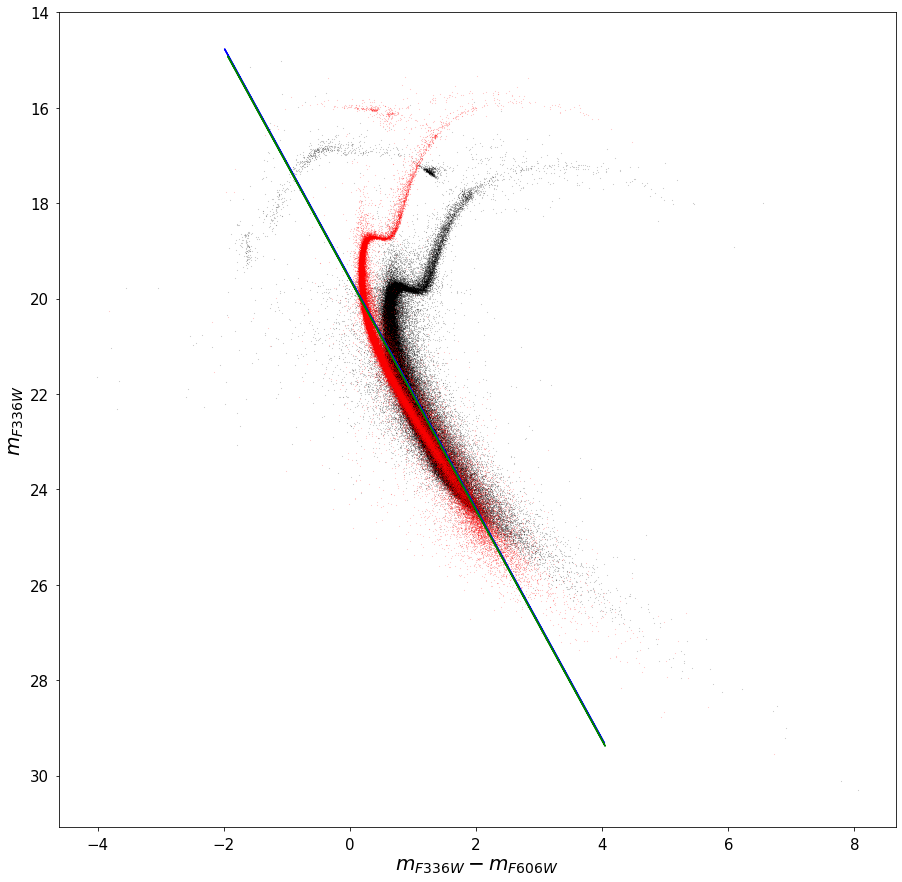

In [4]:
def main_seq(targ1, targ2):
    
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'ultralight',
            'size': 20,
            }
    
    y1n = df1['# Col.  9: F336W calibrated magnitude\n'].to_numpy()
    x1n = df1['Color index'].to_numpy()
    Y1 = []
    X1 = []
    
    for i in range(len(y1n)):
        if y1n[i] > cut1:
            Y1.append(y1n[i])
            X1.append(x1n[i]) 
                
    y2n = df2['# Col.  9: F336W calibrated magnitude\n'].to_numpy()
    x2n = df2['Color index'].to_numpy()
    Y2 = []
    X2 = []
    
    for i in range(len(y2n)):
        if y2n[i] > cut2:
            Y2.append(y2n[i])
            X2.append(x2n[i]) 
    
    X1 = numpy.array(X1)
    X2 = numpy.array(X2)
    Y1 = numpy.array(Y1)
    Y2 = numpy.array(Y2)
    
    p_opt1, p_cov1 = cf(lin_func, X1, Y1)
    p_opt2, p_cov2 = cf(lin_func, X2, Y2)
    
    slope = (p_opt1[0] + p_opt2[0])/2
    
    x1 = df1['Color index']
    x2 = df2['Color index']
    y1 = df1['# Col.  9: F336W calibrated magnitude\n']
    y2 = df2['# Col.  9: F336W calibrated magnitude\n']
    xmin = min(x1.min(), x2.min())
    xmax = max(x1.max(), x2.max())
    ymin = min(y1.min(), y2.min())
    ymax = max(y1.max(), y2.max())
    
    X1 = X1[(X1 > xmin+2) & (X1 < xmax-4)]
    X2 = X2[(X2 > xmin+2) & (X2 < xmax-4)]
    
    
    plt.figure(figsize = (15, 15))
    plt.plot(X1, lin_func(X1, slope, p_opt1[1]), color = 'blue')
    plt.plot(X2, lin_func(X2, slope, p_opt2[1]), color = 'green')
    plt.scatter(x1, y1, s = 0.005, color = 'black')  
    plt.scatter(x2, y2, s = 0.005, color = 'red')
    #plt.plot(x1,numpy.full(df1.shape[0],cut1),c = [0.5,0.5,0.5])
    #plt.plot(x2,numpy.full(df2.shape[0],cut2),c = [0.5,0.5,0.5])
    plt.gca().invert_yaxis()
    #plt.title("NGC"+targ, fontsize = 30, y = 1.01, fontdict = font)
    plt.xlabel(r'$m_{F336W} - m_{F606W}$', fontsize = 20, fontdict = font)
    plt.ylabel(r'$m_{F336W}$', fontsize = 20, fontdict = font)
    plt.xlim = (xmin, xmax)
    plt.ylim = (ymin, ymax)
    plt.tick_params(labelsize=15, pad = 6)
    plt.savefig("D:\IIT material\Krittika python project\main_seq.png")
    plt.show()
    
    dist_mod = abs((p_opt1[1] - p_opt2[1]) / (1+ (slope)**2 )**0.5) 
    ratio = 10**(dist_mod/5)
    dist = ratio * 10.4
    print(dist_mod, ratio, dist)
    
main_seq("2808", "5272")    


In [5]:
import read_mist_models

filename = r"D:\IIT material\Krittika python project\MIST_iso_63486166421f6.iso.cmd"
iso = read_mist_models.ISOCMD(filename)

import astropy.coordinates as coord
import astropy.units as u

distance = 9.6 * u.kpc
distmod = coord.Distance(distance).distmod.value 
distmod

def iso_fit(i):

    phase_mask = (iso.isocmds[i]['phase'] >= 0) & (iso.isocmds[i]['phase'] < 3)
    main_sequence = iso.isocmds[i][phase_mask]

    mag = main_sequence['WFC3_UVIS_F275W'] + distmod
    color = main_sequence['WFC3_UVIS_F275W'] - main_sequence['WFC3_UVIS_F336W']
    
    return color, mag

#print(iso_fit(0))

0.012142367040561219 1.0056074297766944 10.458317269677622
Reading in: D:\IIT material\Krittika python project\MIST_iso_63486166421f6.iso.cmd


In [6]:
def arrange(n):
    for i in range(0, n+1):    
        with open(r"D:\IIT material\Krittika python project\isodata\data"+str(i)+".txt", 'r') as fr, open(r"D:\IIT material\Krittika python project\isodata\arrdata"+str(i)+".txt", 'w') as fw:
            lines = fr.readlines()
            
            for line in lines:
                fw.write(re.sub('[\t ]+',' ', line))
        
arrange(5)        

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\IIT material\\Krittika python project\\isodata\\data0.txt'

In [12]:
k = 0

with open(r"D:\IIT material\Krittika python project\output272539174490.dat.txt", 'r') as f, open(r"D:\IIT material\Krittika python project\output.txt", 'w') as ff:
    lines = f.readlines()
    
    for line in lines:   
        ff.write(re.sub('[\t ]+',' ', line))

    l = lines[0].split
        
with open(r"D:\IIT material\Krittika python project\output.txt", 'r') as f:
    lines = f.readlines()
    
    i = 0
    for line in lines:
        if line[0] == "#":
            i += 1
        else:    
            with open("D:\IIT material\Krittika python project\isodata\iso"+str(i)+".txt", 'a') as fw:
                fw.write(line)
                
        k = i - 1
                
head = []

with open(r"D:\IIT material\Krittika python project\output.txt", 'r') as f:
    lines = f.readlines()
    
    l = lines[0].split()
    
    for i in range(len(l)):
        if l[i] != "#":
            head.append(l[i])
            
print(k)            

17


In [13]:
def isochrone(i):
    d = pd.read_csv(r"D:\IIT material\Krittika python project\isodata\iso"+str(i)+".txt", sep = ' ')
    
    d.columns = head
    
    d.drop(d[(d['pmode'] < 0) & (d['pmode'] >= 3)].index, inplace = True)
    
    d.index = pd.RangeIndex(len(d.index))
    d.index = range(len(d.index))
    
    col = d['F275Wmag'] - d['F336Wmag']
    magn = d['F275Wmag'] + distmod
    
    return col, magn
    
    dd = d['pmode'].to_numpy()
    #return dd

isochrone(1)

(0      2.188
 1      2.188
 2      3.021
 3      3.101
 4      3.193
        ...  
 237    3.346
 238    3.279
 239    3.243
 240    3.220
 241   -0.038
 Length: 242, dtype: float64,
 0      37.256356
 1      37.255356
 2      36.225356
 3      35.922356
 4      34.916356
          ...    
 237    20.245356
 238    20.299356
 239    20.331356
 240    20.359356
 241    44.719356
 Name: F275Wmag, Length: 242, dtype: float64)

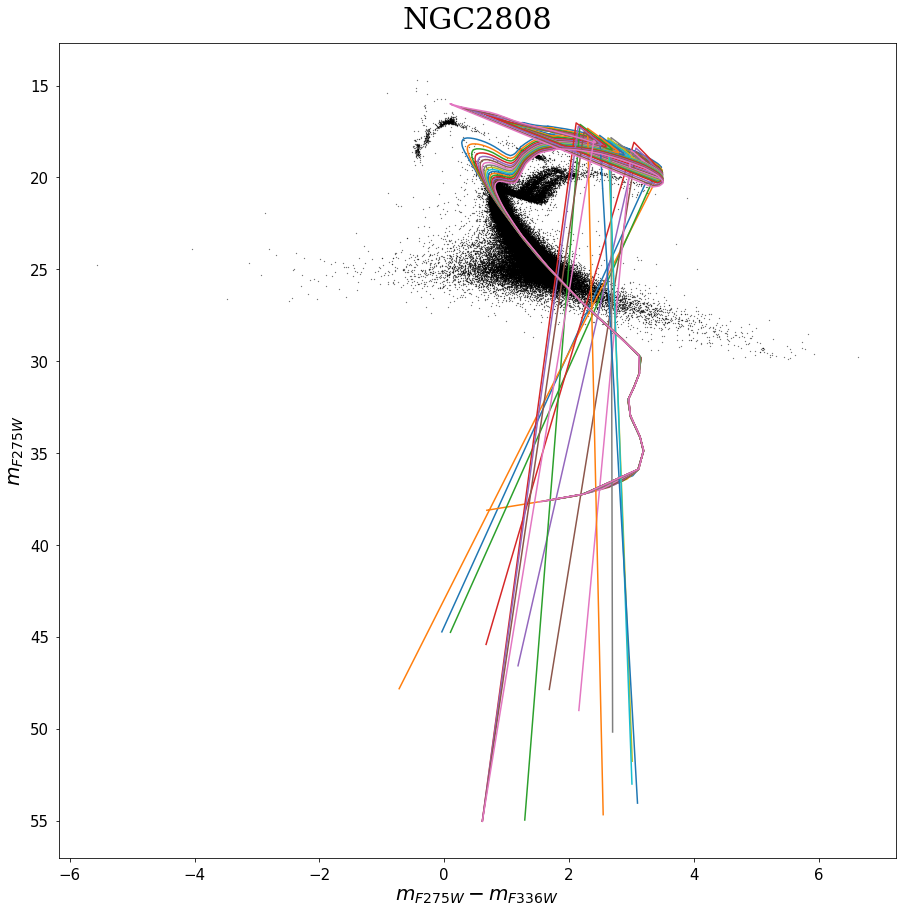

In [14]:
def col_mag(targ):
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'ultralight',
            'size': 20,
            }
      
    x1 = df1['# Col.  3: F275W calibrated magnitude\n'] - df1['# Col.  9: F336W calibrated magnitude\n']
    y1 = df1['# Col.  3: F275W calibrated magnitude\n']

    plt.figure(figsize = (15, 15))
    
    for i in range(1, k+1):
        col, mag = isochrone(i)
        plt.plot(col, mag)
        
    plt.scatter(x1, y1, s = 0.05, color = 'black')  
    plt.gca().invert_yaxis()
    plt.title("NGC"+targ, fontsize = 30, y = 1.01, fontdict = font)
    plt.xlabel(r'$m_{F275W} - m_{F336W}$', fontsize = 20, fontdict = font)
    plt.ylabel(r'$m_{F275W}$', fontsize = 20, fontdict = font)
    plt.tick_params(labelsize=15, pad = 6)
    #plt.show()

col_mag("2808")